# Digit classification using template matching with acoustic features

In [1]:
from pathlib import Path
Path.ls = lambda x: list(x.iterdir())
import librosa
from librosa import display
import IPython.display
import numpy as np
from scipy.ndimage import gaussian_filter
import pandas as pd
from tqdm.notebook import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 16})

In [3]:
# Path to data directory and recordings directory
DATA = Path("../../data/")
RECORDINGS = DATA/"audio-recordings"

## Load a waveform for testing

In [4]:
def load_wav(filename):
    return librosa.core.load(filename, sr=None, mono=True)

In [5]:
def plot_wave(data, figsize=(20, 10), title="", xlabel="Samples", ylabel=""):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
def plot_waves(data:list, data_labels:list, figsize=(20, 10), title="", xlabel="Samples", ylabel=""):
    """Plots multiple waveforms on the same axes"""
    n = len(data)
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(n):
        ax.plot(data[i], label=data_labels[i])
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [6]:
data, sr = load_wav(DATA/"processed"/"001234.wav")

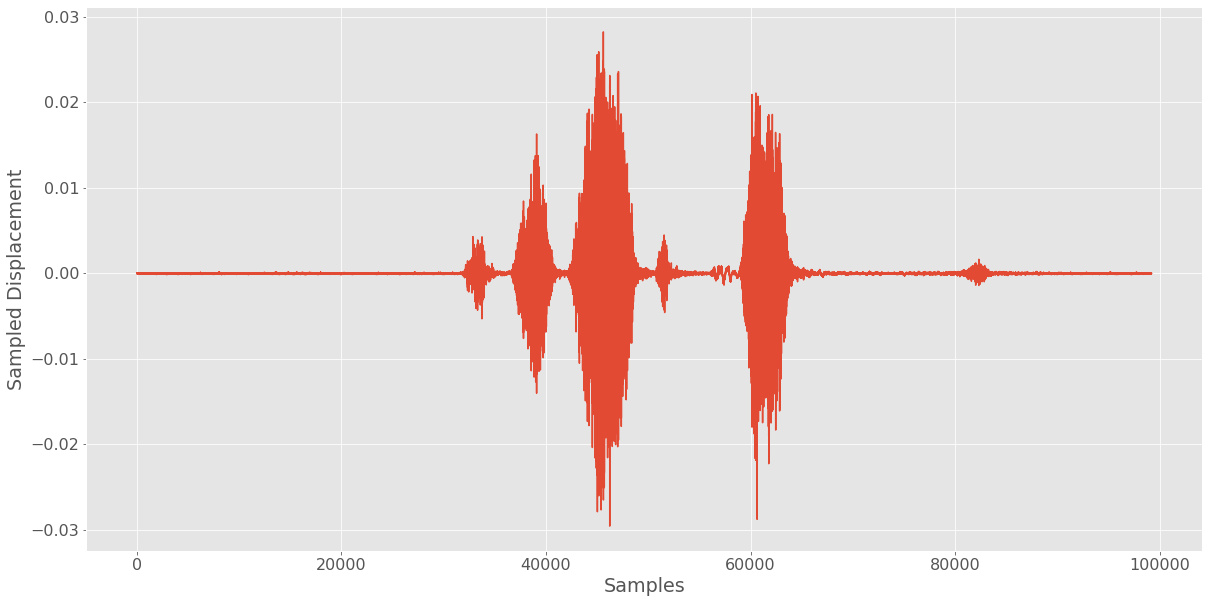

In [7]:
plot_wave(data, ylabel="Sampled Displacement")

## Preprocessing

### Trim silence from beginning and end

In [8]:
def trim(signal, top_db=30):
    trimmed, idx = librosa.effects.trim(signal, top_db=top_db)
    return trimmed

Text(0.5, 1.0, 'After Trimming')

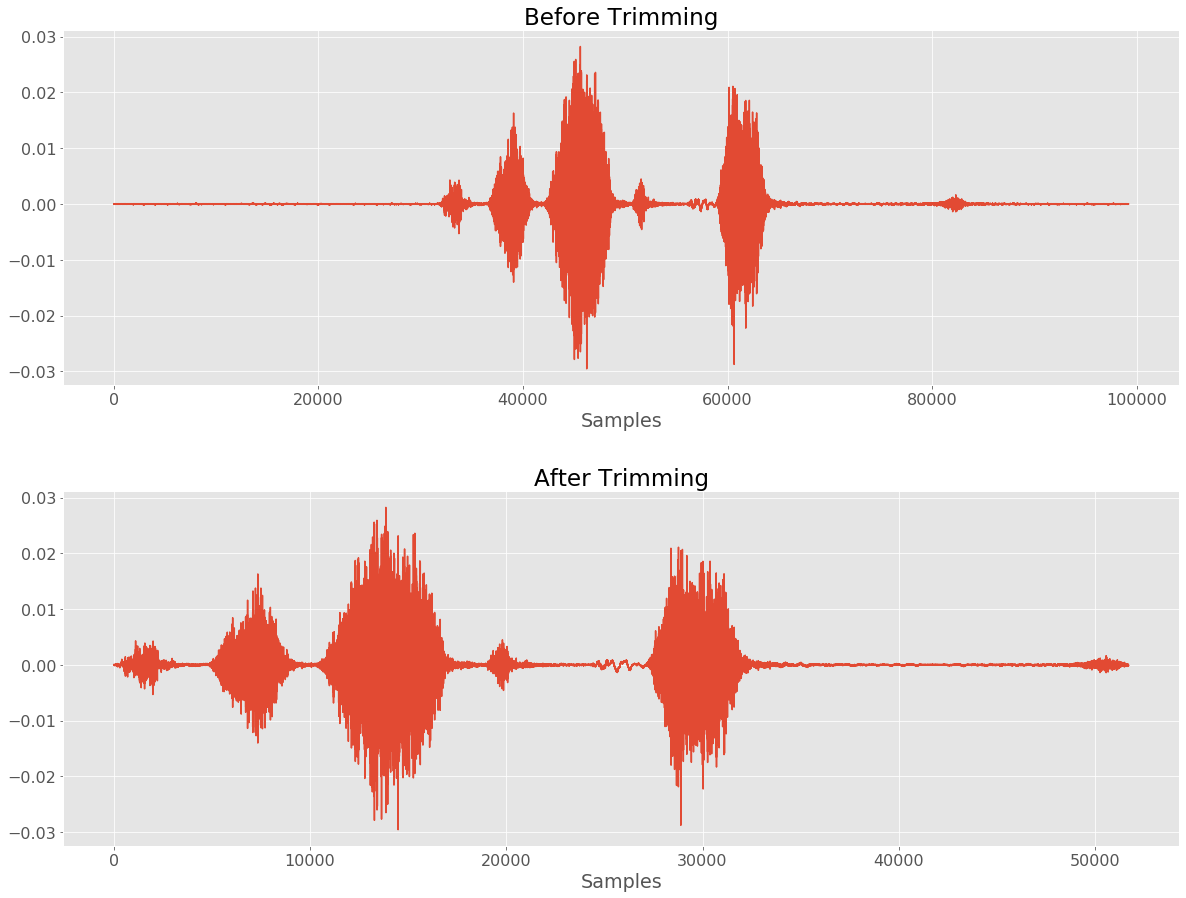

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3)

ax1.plot(data)
ax1.set_xlabel("Samples")
ax1.set_title("Before Trimming")

ax2.plot(trim(data))
ax2.set_xlabel("Samples")
ax2.set_title("After Trimming")

### Generate smoothed amplitude signals

We apply preprocessing steps similar to those used by Seniuk and Blostein in *Pen acoustic emissions for text and gesture recognition* (2009) and *Pen-chant: Acoustic emissions of handwriting and drawing* (2009).

We will attempt to use similar template matching methods to Seniuk and Blostein, in order to compare these to the deep learning based techniques.

In [11]:
def smoothed_amplitude(signal, sr):
    signal = np.abs(signal)
    # Set sigma such that six standard deviations is 10ms
    sigma  = (sr * 0.010) / 6
    signal = gaussian_filter(signal, sigma, mode="nearest")
    return signal

In [12]:
trimmed_data = trim(data)

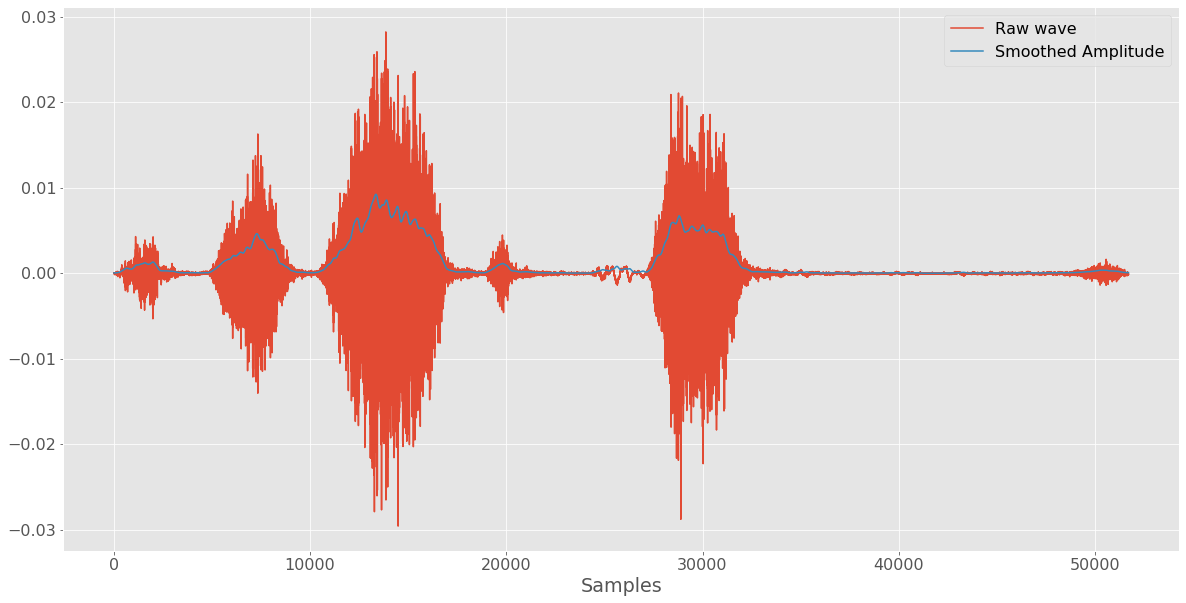

In [13]:
plot_waves([trimmed_data, smoothed_amplitude(trimmed_data, sr)], 
           data_labels=["Raw wave", "Smoothed Amplitude"])

### Amplitude normalisation

In [16]:
def normalise_amplitude(signal):
    return signal / signal.max()

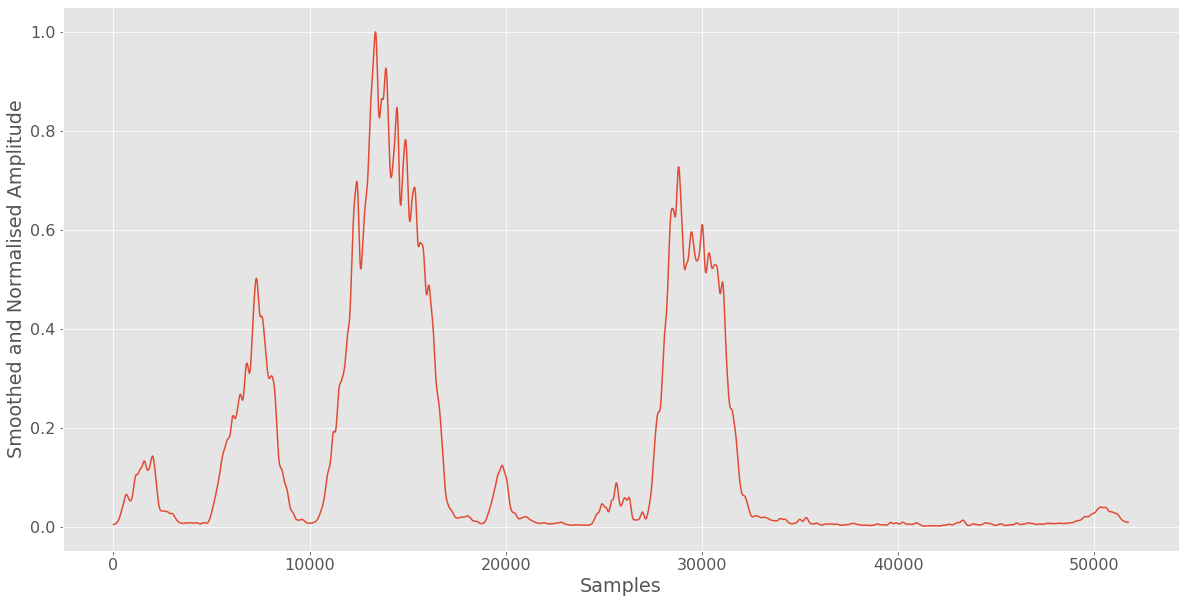

In [17]:
plot_wave(normalise_amplitude(smoothed_amplitude(data, sr)), ylabel="Smoothed and Normalised Amplitude")

### Segmentation

We are already using `librosa.effects.trim` to trim silence from the 2 second audio segments. Librosa does provide a method for splitting by silence, but here we show how we can perform the same task using the smoothed amplitude.

Our data for digit classification was collected in a way that eliminates the need for segmenting recordings into individual digits, however this functionality might be useful if we want to use our classifier on recordings of strings of digits. 

In [18]:
data, sr = load_wav(DATA/"audio-recordings/Record-073.wav")
data = data[sr*21:sr*29]
extra_smooth_data = normalise_amplitude(smoothed_amplitude(data, sr*100))

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


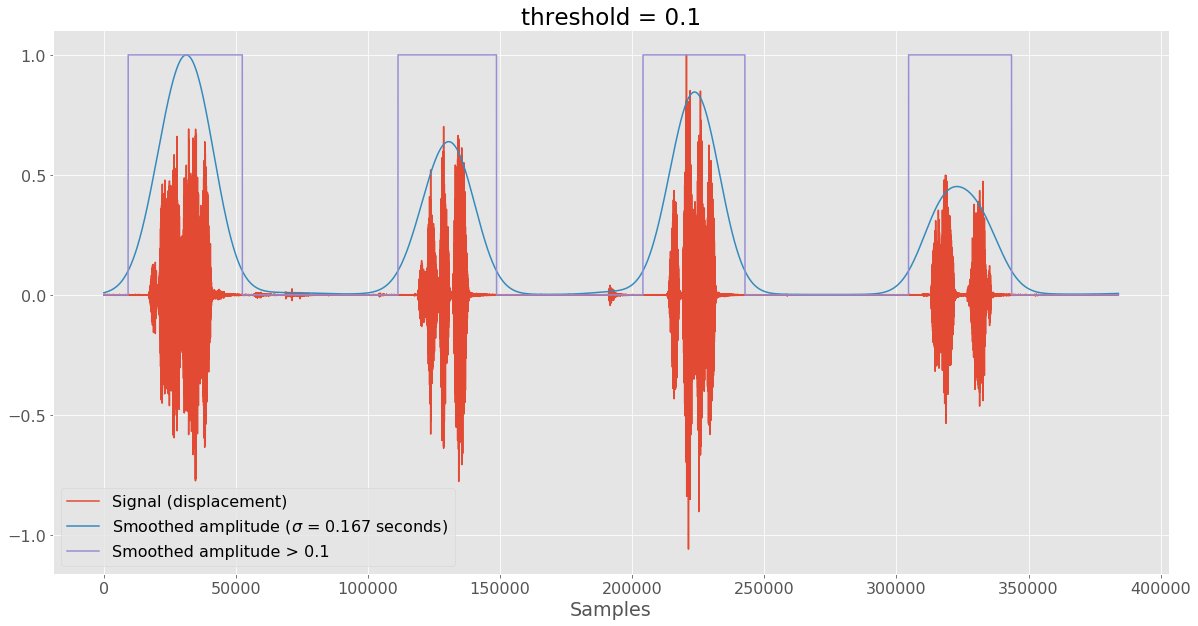

In [19]:
thresh = 0.1
plot_waves([normalise_amplitude(data), extra_smooth_data, extra_smooth_data > thresh],
           data_labels=["Signal (displacement)", "Smoothed amplitude ($\sigma$ = 0.167 seconds)", f"Smoothed amplitude > {thresh}"],
           title=f"threshold = {thresh}")

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


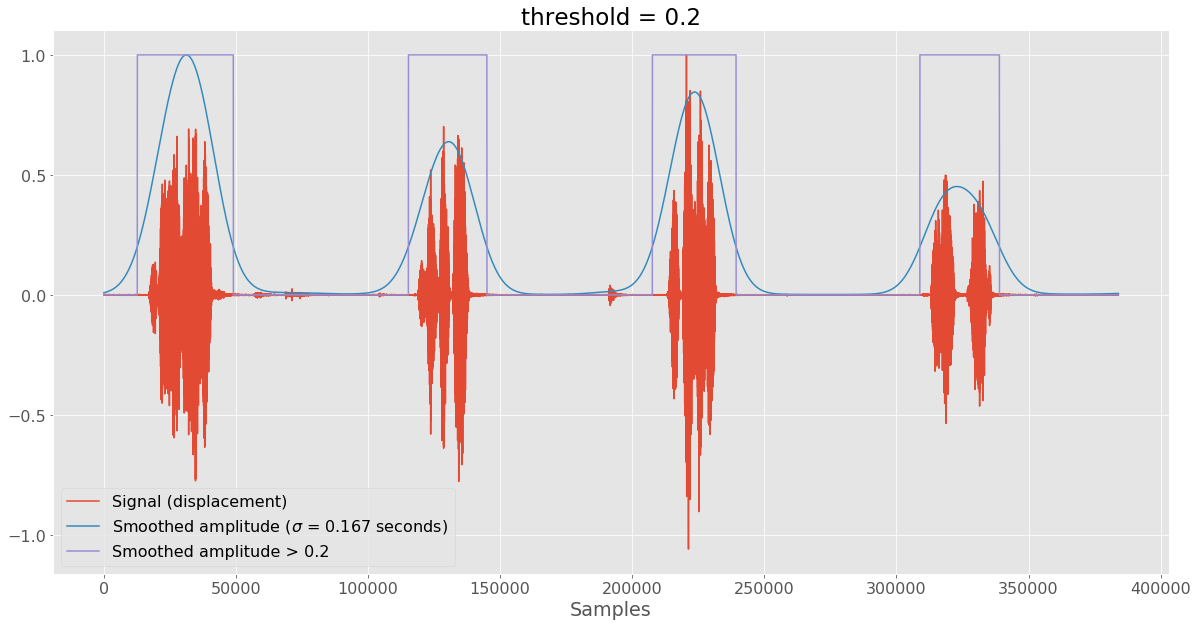

In [20]:
thresh = 0.2
plot_waves([normalise_amplitude(data), extra_smooth_data, extra_smooth_data > thresh],
           data_labels=["Signal (displacement)", "Smoothed amplitude ($\sigma$ = 0.167 seconds)", f"Smoothed amplitude > {thresh}"],
           title=f"threshold = {thresh}")

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


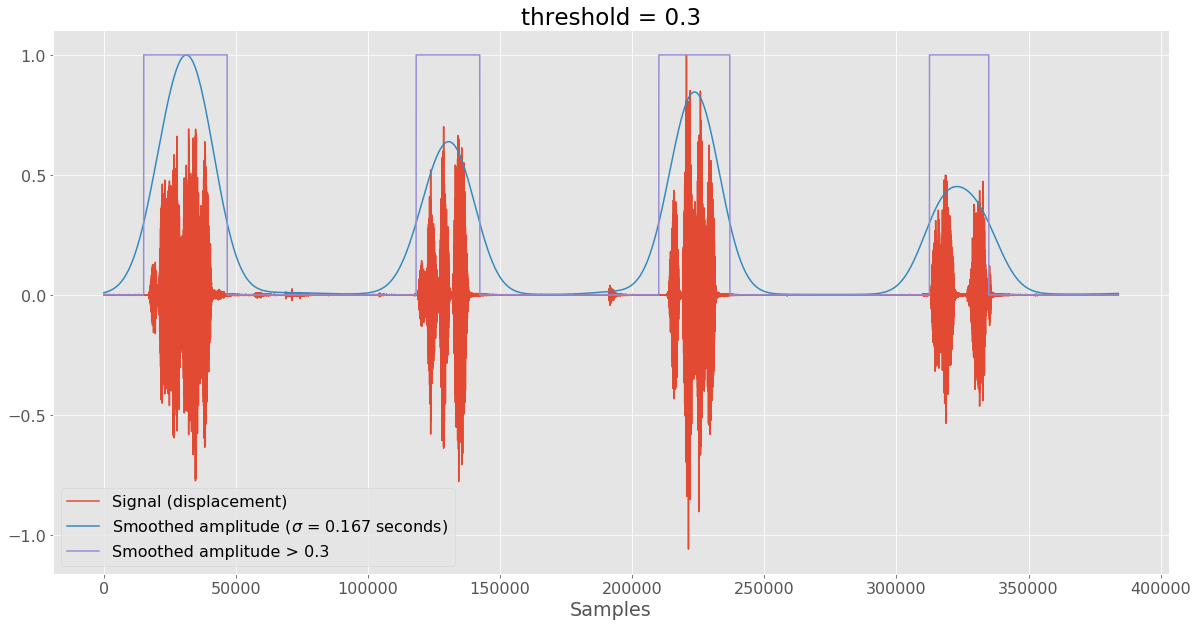

In [21]:
thresh = 0.3
plot_waves([normalise_amplitude(data), extra_smooth_data, extra_smooth_data > thresh],
           data_labels=["Signal (displacement)", "Smoothed amplitude ($\sigma$ = 0.167 seconds)", f"Smoothed amplitude > {thresh}"],
           title=f"threshold = {thresh}")

### Timescale normalisation

From Seniuk, *Pen-chant: Acoustic emissions of handwriting and drawing* (2009):

> "Performance was best when all segments were normalized to span the same time interval."

We will resample segments so that they span 1 second = 48000 samples.

In [22]:
def normalise_timescale(signal, sr, seconds=1):
    target_sr = ((sr ** 2) * seconds) / (len(signal))
    resampled = librosa.core.resample(signal, sr, target_sr)
    return resampled[:sr*seconds]  # Resampling might not give us the exact desired length

In [23]:
data, sr = load_wav(DATA/"audio-recordings/Record-073.wav")
data = data[sr*21:sr*29]
data = data[210000:235000]
smooth_data = normalise_amplitude(smoothed_amplitude(data, sr))

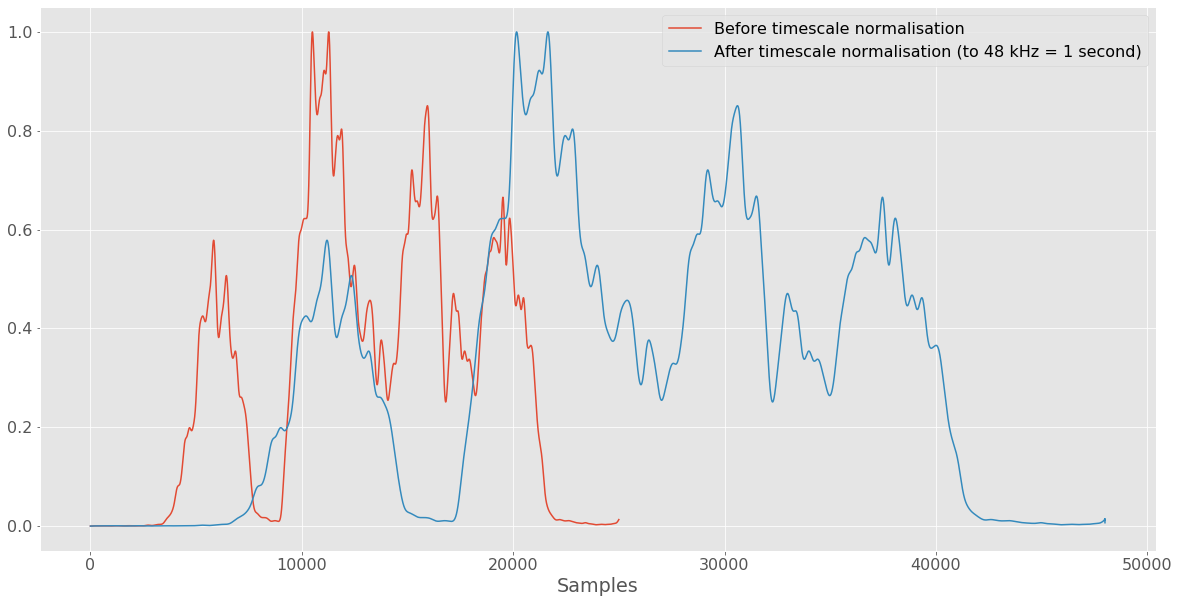

In [24]:
plot_waves([smooth_data, normalise_timescale(smooth_data, sr)],
           ["Before timescale normalisation", "After timescale normalisation (to 48 kHz = 1 second)"])

### Putting it all together

In [25]:
def preprocess(signal, sr):
    signal = trim(signal)
    signal = smoothed_amplitude(signal, sr)
    signal = normalise_amplitude(signal)
    signal = normalise_timescale(signal, sr)
    return signal

## Comparison algorithms

These all assumed preprocessed signals

### Difference of power signals

The similarity of two signals $f_{\text{train}}$ and $f_{\text{test}}$ is defined as:

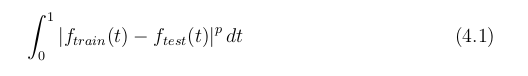

with $ p \in (0, \infty) $

From Seniuk, *Pen-chant: Acoustic emissions of handwriting and drawing* (2009).

In [26]:
def signal_distance_integral(signal1, signal2, p=1):
    assert len(signal1) == len(signal2)
    abs_difference = np.abs(signal1 - signal2)
    #integral = np.power(abs_difference, p).sum() / len(signal1)
    integral = abs_difference.sum()  # Changed so it runs faster
    return integral

In [27]:
signal1, sr = load_wav(DATA/"processed"/"001234.wav")
signal2, sr = load_wav(DATA/"processed"/"002468.wav")

signal1 = preprocess(signal1, sr)
signal2 = preprocess(signal2, sr)

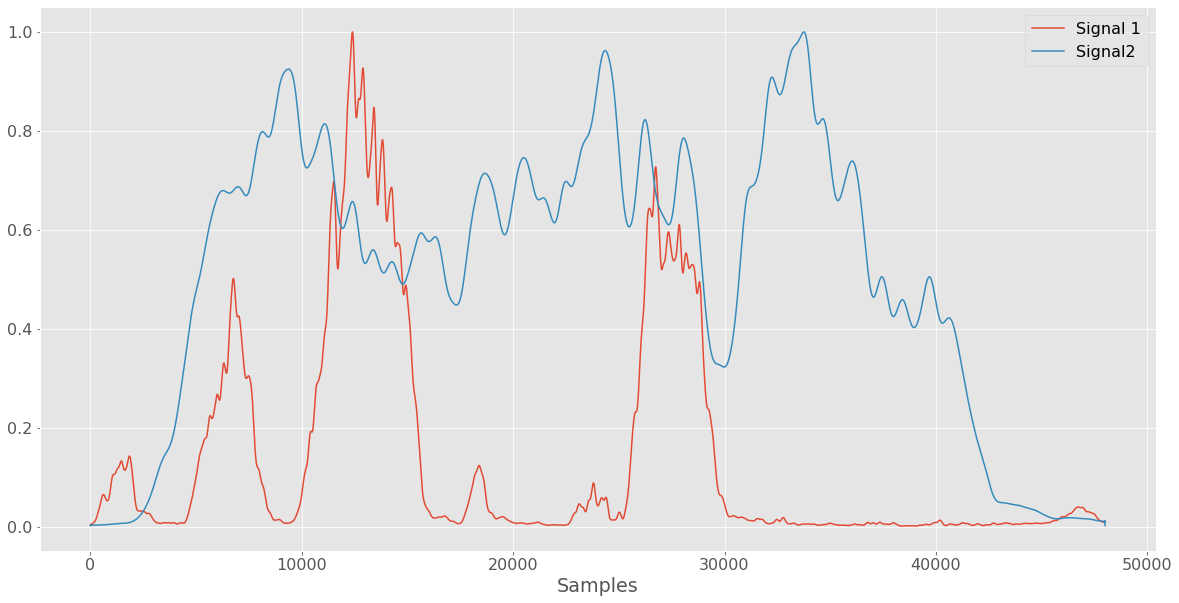

In [28]:
plot_waves([signal1, signal2],
           ["Signal 1", "Signal2"])

In [29]:
signal_distance_integral(signal1, signal2)

19392.107

### Edit distance 

In [30]:
from edit_dist import *

In [28]:
test_edit_distance()

In [29]:
def signal_distance_edit(signal1, signal2):
    sr = len(signal1)  # Assume normalised signals
    peaks1 = get_peaks(signal1, sr)
    peaks2 = get_peaks(signal2, sr)
    return edit_distance(peaks1, peaks2, sub_cost_mult)

In [54]:
signal_distance_edit(signal1, signal2)

7.146037282531459

## Building a classifier using these features

### Load data

In [32]:
df = pd.read_csv(DATA/"labels.csv")

In [33]:
train_x = []
train_y = []
valid_x = []
valid_y = []

for i, row in tqdm(df.iterrows()):
    samples, sr = load_wav(DATA/"processed"/row.filename)
    samples = preprocess(samples, sr)
    if row.is_valid == 1:
        valid_x.append(samples)
        valid_y.append(row.label)
    else:
        train_x.append(samples)
        train_y.append(row.label)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [34]:
class TemplateMatchingClassifier:
    def __init__(self, distance_func):
        self.distance = distance_func
    
    def fit(self, x, y):
        self.data = list(zip(x, y))
    
    def predict(self, x, k=1, use_tqdm=True):
        assert k <= len(self.data)
        # Essentially a brute force nearest neighbour search
        predictions = []
        if use_tqdm:
            x = tqdm(x)
        for x_ in x:
            nn_dists = np.array([np.inf for i in range(k)])  # distances of k nearest neighbours
            nn_classes = np.array([None for i in range(k)])  # classes of k nearest neighbours (sorted by distance)
            for train_x, train_y in self.data:
                dist = self.distance(x_, train_x)
                if dist < nn_dists[-1]:
                    nn_dists[-1] = dist
                    nn_classes[-1] = train_y
                    sort_idx = np.argsort(nn_dists)  # don't actually need to do full sort, oh well
                    nn_dists = nn_dists[sort_idx]
                    nn_classes = nn_classes[sort_idx]
            preds, counts = np.unique(nn_classes, return_counts=True)
            # Sort first by frequency of that class within the closest k neighbours,
            # then by distance to closest example.
            class_ranks = sorted(range(len(preds)),
                                 key=lambda x:(counts[x], np.where(nn_classes==preds[x])[0][0]))
            predictions.append(preds[class_ranks[0]])
        return np.array(predictions)

In [35]:
%%timeit
signal_distance_edit(train_x[1], train_x[2])

10 loops, best of 5: 63.4 ms per loop


In [36]:
%%timeit
signal_distance_integral(train_x[1], train_x[2])

The slowest run took 15.03 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 25.7 µs per loop


### Make predictions with signal difference integral

In [37]:
tpl_int = TemplateMatchingClassifier(signal_distance_integral)
tpl_int.fit(train_x, train_y)

In [85]:
assert np.all(tpl_int.predict(train_x[:50]) == train_y[:50])

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [88]:
%%time
tpl_int_preds = tpl_int.predict(valid_x)

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



CPU times: user 47.7 s, sys: 73.3 ms, total: 47.8 s
Wall time: 47.9 s


In [102]:
accuracy_score(valid_y, tpl_int_preds)

0.6357142857142857

### Make predictions with signal difference integral

In [89]:
tpl_edit = TemplateMatchingClassifier(signal_distance_edit)
tpl_edit.fit(train_x, train_y)

In [93]:
assert np.all(tpl_edit.predict(train_x[:5]) == train_y[:5])

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [94]:
%%time
tpl_edit_preds = tpl_edit.predict(valid_x)

/home/jeff/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



CPU times: user 16h 41min 43s, sys: 29.5 s, total: 16h 42min 13s
Wall time: 16h 42min 56s


In [101]:
accuracy_score(valid_y, tpl_edit_preds)

0.1375